## Installations & Imports

In [45]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import re
from wordcloud import WordCloud
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from gensim import corpora, models
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

## Accessing Titles

In [97]:
# Define the path to OAuth2 credentials JSON file
creds_path = r'C:\Users\cathe\practical-data-science-tutorial\src\data\credentials.json'

# Define the name of Google Sheet
google_sheet_name = 'Draft-dataset'

# Define the name of the specific sheet within the Google Sheet
specific_sheet_names = ['Health and medical sciences', 'Social sciences', 'Business, economics and management']

# Initialize the Google Sheets client
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(creds_path, scope)
client = gspread.authorize(creds)

article_names = []

for specific_sheet_name in specific_sheet_names:
    # Open the Google Sheet
    sheet = client.open(google_sheet_name).worksheet(specific_sheet_name)

    # Get list of article names from the sheet
    papers = sheet.col_values(3)[1:]

    # Add all article names to a single list
    article_names.extend(papers)

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\gspread\auth.py:63: DeprecationWarning:

[Deprecated][in version 6.0.0]: client_factory will be replaced by gspread.http_client types



In [98]:
article_names[0]

'The psychological impact of quarantine and how to reduce it: rapid review of the evidence'

In [99]:
len(article_names)

1242

## Exploration of Titles

c:\Users\cathe\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


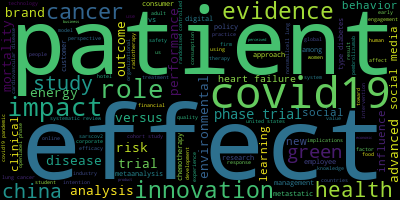

In [9]:
article_names_cleaned = np.vectorize(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))(article_names)

article_names_lower = np.vectorize(lambda x: x.lower())(article_names_cleaned)

all_titles = ','.join(list(article_names_lower))

wordcloud = WordCloud()

wordcloud.generate(all_titles)

wordcloud.to_image()

## Preprocessing Titles

In [10]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [42]:
# Define stopwords to remove
custom_stopwords = set(['the', 'a', 'of', 'in', 'an', 'covid19', 'sarscov2'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Tokenize the title (break down into words)
    words = word_tokenize(title_lower)

    # Remove stopwords
    words = [word for word in words if word not in custom_stopwords]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Map POS tags to WordNet tags for lemmatisation
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        else:
            return wordnet.VERB

    # Lemmatisation of verbs (converts all verbs that are the same to the infinitive) & removal of nouns
    lemmatised_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_words if not pos.startswith('N')]
    #lemmatised_words = [lemmatizer.lemmatize(word, pos='v') for word, pos in tagged_words]

    # Join the words back into a processed title
    processed_title = ' '.join(lemmatised_words)

    return processed_title

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names]
preprocessed_titles[0:4]

['psychological and how to reduce it rapid',
 'global regional and national and live with for 354 and for 195 and 19902017 systematic for global 2017',
 'novel global',
 'and italy what next']

In [44]:
before_preprocessing = " ".join(article_names)
before_preprocessing = re.sub(r'[^a-zA-Z0-9\s]', '', before_preprocessing)
before_preprocessing = before_preprocessing.lower()

after_preprocessing = " ".join(preprocessed_titles)

# Function to plot word frequencies with Plotly
def plot_word_frequencies(data, title):

    # Count the occurrences of each word
    words = data.split()
    word_counts = Counter(words)

    # Order the results by word counts
    ordered_word_counts = word_counts.most_common(20)
    
    # Create a Plotly bar chart
    fig = px.bar(
        x=[word[0] for word in ordered_word_counts],
        y=[word[1] for word in ordered_word_counts],
        labels={'x': 'Words', 'y': 'Frequency'},
        title=f"Top 10 Most Frequent Words - {title}",
    )

    # Show the chart
    fig.show()

# Plot before preprocessing
plot_word_frequencies(before_preprocessing, "Before Preprocessing")

# Plot after preprocessing
plot_word_frequencies(after_preprocessing, "After Preprocessing")

[('of', 826), ('and', 801), ('the', 631), ('in', 575), ('a', 327), ('on', 244), ('with', 237), ('for', 194), ('to', 154), ('covid19', 154), ('patients', 139), ('from', 118), ('cancer', 112), ('effect', 90), ('social', 87), ('study', 86), ('role', 81), ('trial', 79), ('effects', 74), ('innovation', 74)]


[('and', 801), ('on', 244), ('with', 237), ('for', 194), ('to', 154), ('from', 118), ('social', 87), ('be', 54), ('green', 52), ('or', 51), ('environmental', 51), ('randomise', 49), ('2', 45), ('do', 42), ('as', 38), ('how', 37), ('3', 36), ('cardiovascular', 36), ('plus', 34), ('systematic', 33)]


In [56]:
before_preprocessing = " ".join(article_names)
before_preprocessing = re.sub(r'[^a-zA-Z0-9\s]', '', before_preprocessing)
before_preprocessing = before_preprocessing.lower()

after_preprocessing = " ".join(preprocessed_titles)

# Count the occurrences of each word
words = before_preprocessing.split()
word_counts = Counter(words)
words2 = after_preprocessing.split()
word_counts2 = Counter(words2)

# Order the results by word counts
ordered_word_counts = word_counts.most_common(30)
ordered_word_counts2 = word_counts2.most_common(30)

# Create dataframe to store words
df = pd.DataFrame(columns = ['Word', 'Count', 'Colour'])

# Add all original words to dataframe as blue
for word, count in ordered_word_counts:
    df.loc[len(df.index)] = [word, count, 'blue'] 

# Change bar colour of preprocessed words to be red
for word, count in ordered_word_counts2:
    if word in df['Word'].values:
        index_to_change = df[df['Word'] == word].index[0]
        df.at[index_to_change, 'Colour'] = 'red'

# Create a Plotly bar chart
fig = px.bar(df, x='Word', y='Count', color='Colour',
             category_orders={'Word': df['Word'].tolist()},
             title = 'Words Removed and Remaining After Preprocessing Paper Titles')

# Change labels and order words by counts not colour
legend_labels = {'blue': 'Before preprocessing', 'red': 'After preprocessing'}
fig.for_each_trace(lambda t: t.update(name=legend_labels.get(t.name, t.name)))
fig.show()

## Document-Term Matrix (DTM)

In [34]:
vectorizer = CountVectorizer()

# Fit and transform the preprocessed titles to create the DTM
dtm = vectorizer.fit_transform(preprocessed_titles)

# Get the feature names (terms) from the vectoriser
feature_names = vectorizer.get_feature_names_out()
dtm_array = dtm.toarray()

# Print the DTM and feature names
print("Document-Term Matrix (DTM):")
print(dtm_array)
print("Feature Names (Terms):")
print(feature_names)

Document-Term Matrix (DTM):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Feature Names (Terms):
['000' '012' '067' ... 'youth' 'zero' 'zoledronic']


## Latent Dirichlet Allocation (LDA)

### Using sklearn

In [35]:
# Number of topics
num_topics = 3

# Initialize the LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the LDA model to the DTM
lda.fit(dtm_array)

# Get the topic-word distributions
topic_word_distributions = lda.components_

# Get the document-topic distributions
document_topic_distributions = lda.transform(dtm_array)

# Print the top words for each topic
n_top_words = 5
for topic_idx, topic in enumerate(topic_word_distributions):
    top_terms_idx = topic.argsort()[:-n_top_words - 1:-1]
    top_terms = [feature_names[i] for i in top_terms_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_terms)}")

# Print the topic distribution for each document
for doc_idx, doc_topics in enumerate(document_topic_distributions):
    print(f"Article {doc_idx + 1}: {doc_topics}")

Topic 1: and, on, with, to, or
Topic 2: and, with, systematic, for, advanced
Topic 3: and, for, from, on, social
Article 1: [0.90013509 0.04621447 0.05365044]
Article 2: [0.01965091 0.95962879 0.0207203 ]
Article 3: [0.75900562 0.12975321 0.11124116]
Article 4: [0.55842557 0.36792157 0.07365286]
Article 5: [0.84646443 0.07646837 0.0770672 ]
Article 6: [0.05256109 0.09036904 0.85706987]
Article 7: [0.58322851 0.08437894 0.33239255]
Article 8: [0.73365785 0.11120709 0.15513506]
Article 9: [0.03605329 0.91079161 0.05315509]
Article 10: [0.82062547 0.084335   0.09503953]
Article 11: [0.61706362 0.34850514 0.03443125]
Article 12: [0.23145303 0.73533268 0.03321429]
Article 13: [0.86147623 0.06889954 0.06962423]
Article 14: [0.0357257  0.92826164 0.03601266]
Article 15: [0.11155552 0.77076144 0.11768305]
Article 16: [0.85137552 0.0777376  0.07088688]
Article 17: [0.0319258  0.83678762 0.13128659]
Article 18: [0.64429897 0.18882999 0.16687104]
Article 19: [0.88512893 0.05431643 0.06055464]
Art

### Using genism

In [100]:
# Download NLTK data for stopwords and lemmatisation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Define stopwords to remove
custom_stopwords = set(['the', 'a', 'of', 'in', 'an', 'covid19', 'sarscov2'])
custom_keep_nouns = set(['impact', 'impacts', 'effect', 'effects', 'cause', 'causes', 'influence', 
                         'influences', 'consequence', 'consequences', 'result', 'results', 'outcome', 
                         'outcomes', 'origin', 'origins', 'source', 'sources', 'reason', 'reasons', 
                         'stimulus', 'stimuli', 'motivation', 'motivations'])

# Initialize lemmatiser
lemmatizer = WordNetLemmatizer()

def preprocess_title(title):
    # Remove non-alphanumeric characters
    title_alpha = re.sub(r'[^a-zA-Z0-9\s]', '', title)

    # Convert to lowercase
    title_lower = title_alpha.lower()

    # Break down into individual words
    words = word_tokenize(title_lower)

    # Remove stopwords
    words = [word for word in words if word not in custom_stopwords]

    # Part-of-Speech (POS) tagging
    tagged_words = pos_tag(words)

    # Map POS tags to WordNet tags for lemmatisation
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        else:
            return wordnet.VERB
        
    lemmatised_words = []

    # Lemmatisation of verbs (converts all verbs that are the same to the infinitive) & removal of nouns (except causal nouns)
    for word, pos in tagged_words:
        if word in custom_keep_nouns or not pos.startswith('N'):
            lemmatised_words.append(lemmatizer.lemmatize(word, get_wordnet_pos(pos)))

    return lemmatised_words

# Apply preprocessing to all titles
preprocessed_titles = [preprocess_title(title) for title in article_names]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\cathe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [101]:
# Reduce paper title lists to single strings
before_preprocessing = " ".join(article_names)
words = before_preprocessing.split()
words2 = [word for sublist in preprocessed_titles for word in sublist]

# Count occurences of each word
word_counts = Counter(words)
word_counts2 = Counter(words2)

# Order the results by word counts
ordered_word_counts = word_counts.most_common(30)
ordered_word_counts2 = word_counts2.most_common(30)

# Create dataframe to store words
df = pd.DataFrame(columns = ['Word', 'Count', 'Colour'])

# Add all original words to dataframe as blue
for word, count in ordered_word_counts:
    df.loc[len(df.index)] = [word, count, 'blue'] 

# Change bar colour of preprocessed words to be red
for word, count in ordered_word_counts2:
    if word in df['Word'].values:
        index_to_change = df[df['Word'] == word].index[0]
        df.at[index_to_change, 'Colour'] = 'red'

# Create a Plotly bar chart
fig = px.bar(df, x='Word', y='Count', color='Colour',
             category_orders={'Word': df['Word'].tolist()},
             title = 'Words Removed and Remaining After Preprocessing Paper Titles')

# Change labels and order words by counts not colour
legend_labels = {'blue': 'Before preprocessing', 'red': 'After preprocessing'}
fig.for_each_trace(lambda t: t.update(name=legend_labels.get(t.name, t.name)))
fig.show()

In [82]:
# Create a dictionary of terms in the preprocessed titles
id2word = corpora.Dictionary(preprocessed_titles)

# Convert the preprocessed titles into a bag-of-words representation
# where each document is represented as a list of (term_id, term_frequency) pairs
corpus = [id2word.doc2bow(word) for word in preprocessed_titles]

In [92]:
# Flatten the list of lists into a list of strings
flattened_titles = [' '.join(words) for words in preprocessed_titles]

# Convert the corpus to TF-IDF representation
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(flattened_titles)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the scatter plot
scatter_df = pd.DataFrame(X_tsne, columns=['X', 'Y'])

# Create the scatter plot
fig = px.scatter(scatter_df, x='X', y='Y', title='t-SNE Scatter Plot of Paper Title Similarity')

# Show the plot
fig.show()

In [94]:
# Flatten the list of lists into a list of strings
flattened_titles = [' '.join(words) for words in preprocessed_titles]

# Convert the corpus to TF-IDF representation
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(flattened_titles)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=3, random_state=42, init='random')
X_tsne = tsne.fit_transform(X)

# Create a DataFrame for the scatter plot
scatter_df = pd.DataFrame(X_tsne, columns=['X', 'Y', 'Z'])

# Create the scatter plot
fig = px.scatter_3d(scatter_df, x='X', y='Y', z='Z', title='t-SNE Scatter Plot of Paper Title Similarity')

# Show the plot
fig.show()

In [83]:
# Define the number of topics you want the LDA model to discover
num_topics = 5

# Initialize and train an LDA model using multicore processing for efficiency
lda_model = models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# Apply the trained LDA model to the corpus to get topic distributions for each document
doc_lda = lda_model[corpus]

# Print the discovered topics along with their top terms
lda_model.print_topics()

[(0,
  '0.051*"on" + 0.023*"and" + 0.022*"for" + 0.022*"effect" + 0.019*"impact" + 0.017*"to" + 0.011*"or" + 0.008*"perceive" + 0.008*"from" + 0.006*"be"'),
 (1,
  '0.091*"and" + 0.028*"social" + 0.025*"on" + 0.020*"with" + 0.020*"for" + 0.018*"effect" + 0.014*"from" + 0.010*"be" + 0.009*"randomise" + 0.009*"2"'),
 (2,
  '0.066*"with" + 0.061*"and" + 0.029*"on" + 0.023*"for" + 0.022*"effect" + 0.017*"to" + 0.012*"from" + 0.011*"environmental" + 0.011*"randomise" + 0.009*"3"'),
 (3,
  '0.138*"and" + 0.031*"for" + 0.023*"on" + 0.021*"from" + 0.019*"effect" + 0.019*"with" + 0.013*"impact" + 0.011*"to" + 0.008*"systematic" + 0.008*"green"'),
 (4,
  '0.098*"and" + 0.034*"to" + 0.020*"on" + 0.016*"with" + 0.013*"effect" + 0.013*"for" + 0.010*"how" + 0.009*"be" + 0.009*"social" + 0.009*"do"')]

In [84]:
# Enable the use of pyLDAvis within a Jupyter Notebook
pyLDAvis.enable_notebook()

# Prepare the data for visualisation
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.047952  0.040367       1        1  25.692138
2      0.035389 -0.079969       2        1  22.241621
1      0.014482 -0.027555       3        1  20.874290
4      0.013284  0.070383       4        1  20.688378
0     -0.111106 -0.003226       5        1  10.503573, topic_info=               Term        Freq       Total Category  logprob  loglift
18             with  192.000000  192.000000  Default  30.0000  30.0000
40               on  192.000000  192.000000  Default  29.0000  29.0000
661          social   69.000000   69.000000  Default  28.0000  28.0000
0               and  642.000000  642.000000  Default  27.0000  27.0000
7                to  121.000000  121.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1337          urban    2.288315   11.090302   Topic5  -5.7826   0.6752
539   environmental    2.306793   42.063776   Topic5  -5.7746  -0.6499
131           china    2.285833   10.898294   Topic5  -5.7837   0.6916
76           public    2.284968   12.499704   Topic5  -5.7841   0.5541
42          advance    2.281617   11.843724   Topic5  -5.7856   0.6065

[369 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
689       2  0.822423           14
527       4  0.865549           16
8         1  0.733556          195
9         1  0.820626     19902017
66        1  0.295671            2
...     ...       ...          ...
18        4  0.119259         with
18        5  0.010370         with
1744      5  0.667692  wordofmouth
1498      3  0.843224         work
371       5  0.667709        would

[589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 5, 1])